In [1]:
from itertools import chain

from scipy.stats import norm
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [86]:
def frac(taille_échantillon, nombre_fragments):
	# On prends chaque échantillon et lui associe un nombre de fractures, converti en int à la volée
	if nombre_fragments > taille_échantillon:
		raise ValueError(
			'\n\n\n'
			'ERREUR: Le nombre de fragments demandé est trop grand, il est impossible de continuer\n'
			'Vous pouvez: \n'
			'\t- Réduire le nombre de fragments demandé, en jouant sur N et sigma\n'
			'\t- Augmenter la taille des échantillons à fracturer\n'
		)
	# Il y aura n - 1 fractures pour obtenir n elements
	nombre_fractures = nombre_fragments - 1
	# Une fracture sera placée avant l'index désigné, donc une fracture
	#   localisée à l'index 1 donnera un morceau de 1 et un de taille - 1
	fractures = set()
	while len(fractures) < nombre_fractures:
		fractures.update(np.random.randint(1, taille_échantillon - 1, nombre_fractures))
	print(list(sorted(fractures))[:10])
	if len(fractures) != nombre_fractures:
		if len(fractures) < nombre_fractures:
			raise RuntimeError('ERREUR: Une erreur s\'est produite: pas assez de fragments')
		fractures = set(list(fractures)[:nombre_fractures])
	fractures = [0] + list(sorted(fractures)) + [taille_échantillon]
	print(list(sorted(fractures))[-10:])
	échantillon_fracturé = [
		fractures[i + 1] - fractures[i] for i in range(nombre_fragments)
	]
	if sum(échantillon_fracturé) != taille_échantillon:
		raise RuntimeError(
			"ERREUR: Une erreur s'est produite lors de la fragmentation, \n"
			f"Nous avons {abs(sum(échantillon_fracturé) - taille_échantillon)}"
			f" fragments de différence entre ce qu'on attendais et ce qu'on a"
		)
	print(list(i for i in sorted(échantillon_fracturé))[:10])
	return échantillon_fracturé

In [124]:
lois = ['normale', 'exponentielle', 'uniforme', 'poisson', 'géométrique']

def fracture(echantillons, n=65952, sigma=100, loi='normale'):
    """
    Fracture une liste d'échantillons en utilisant un nombre de fractures variables de loi n = Norm(N, sigma)
    :param sigma:
    :param n: Ecart-type
    :param echantillons:
    :return:
    """
    #
    échantillons_fracturés = []
    
    n = dict(
        normale = n + np.random.randn(len(echantillons)) * sigma,
        uniforme = np.random.uniform(0, 131206, len(echantillons)),
        poisson = np.random.poisson(65603, len(echantillons)), #erreur
        géométrique = np.random.geometric(1./65603, len(echantillons)),#erreur
        exponentielle = np.random.exponential(1./65603, len(echantillons)) 
    )[loi]

    for i in range(len(echantillons)):
        n[i]=n[i]/len(echantillons)
    
    # On prends chaque échantillon et lui associe un nombre de fractures, converti en int à la volée
    for index, (nombre_fragments, taille_échantillon) in enumerate(zip(map(int, n), echantillons)):

        if nombre_fragments > taille_échantillon:
            raise ValueError(
                '\n\n\n'
                'ERREUR: Le nombre de fragments demandé est trop grand, il est impossible de continuer\n'
                'Vous pouvez: \n'
                '\t- Réduire le nombre de fragments demandé, en jouant sur N et sigma\n'
                '\t- Augmenter la taille des échantillons à fracturer\n'
            )
        # Il y aura n - 1 fractures pour obtenir n elements
        nombre_fractures = nombre_fragments - 1

        # Une fracture sera placée avant l'index désigné, donc une fracture
        #   localisée à l'index 1 donnera un morceau de 1 et un de taille - 1
        fractures = set()
        while len(fractures) < nombre_fractures:
            fractures.update(np.random.randint(1, taille_échantillon - 1, nombre_fractures))
        if len(fractures) != nombre_fractures:
            if len(fractures) < nombre_fractures:
                raise RuntimeError('ERREUR: Une erreur s\'est produite: pas assez de fragments')
            fractures = set(list(fractures)[:nombre_fractures])
        fractures = [0] + list(sorted(fractures)) + [taille_échantillon]
        échantillon_fracturé = [
            fractures[i + 1] - fractures[i] for i in range(len(fractures) - 1)
        ]
        if sum(échantillon_fracturé) != taille_échantillon:
            raise RuntimeError(
                "ERREUR: Une erreur s'est produite lors de la fragmentation, \n"
                f"Nous avons {abs(sum(échantillon_fracturé) - taille_échantillon)}"
                f" fragments de différence entre ce qu'on attendais et ce qu'on a"
                f" ({sum(échantillon_fracturé)} contre {taille_échantillon})"
            )
        échantillon_fracturé = list(i for i in sorted(échantillon_fracturé))
        échantillons_fracturés.append(échantillon_fracturé)

    return échantillons_fracturés

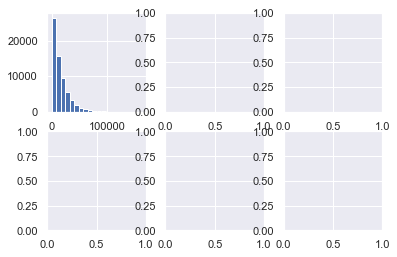

In [132]:
sns.set(color_codes=True)
# sns.distplot(fragments, kde=False, rug=False)
# plt.show()


taille_genome = 1000000
nombre_morceaux = 65603
seuil = 80000


fig, sub = plt.subplots(2, 3)
subplots = []
for x in sub:
    for y in x:
        subplots.append(y)
for plot, loi in zip(subplots, lois):
    fragments = list(chain.from_iterable(fracture([taille_genome] * 1000, nombre_morceaux, loi=loi)))
    plot.hist(fragments, bins=20)
    plt.show()

#fragments = [x for x in fragments if x < seuil]


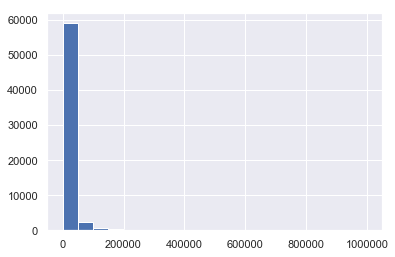